# Radar LPDP (Sample Analytics)

In [13]:
from pathlib import Path
from typing import Dict

import numpy as np

from config import SAMPLE_RATE
from functions.data_processing import analyze_loaded_data, load_file_and_prepare

SAMPLE_RATE_HZ = int(SAMPLE_RATE)
DATA_FILES = [
    Path("live/3m.bin"),
    Path("live/5m.bin"),
    Path("live/10m.bin"),
]

def load_and_analyze(path: Path) -> Dict:
    data_dict, error = load_file_and_prepare(str(path), SAMPLE_RATE_HZ)
    if error:
        raise FileNotFoundError(f"{error}: {path}")
    ch1 = data_dict["ch1"]
    ch3 = data_dict["ch2"]
    analysis = analyze_loaded_data(ch1, ch3, SAMPLE_RATE_HZ, n_samples=data_dict["n_samples"])
    return {"path": path, "data": data_dict, "analysis": analysis}

results = [load_and_analyze(path) for path in DATA_FILES]

## File Metadata

In [14]:
for item in results:
    info = item["analysis"]["file_info"]
    print(f"File: {item['path'].name}")
    print(f"  Duration: {info['duration']:.6f} s")
    print(f"  Samples: {info['n_samples']}")
    print(f"  Sample rate: {info['sample_rate']:.0f} Hz")
    print()

File: 3m.bin
  Duration: 0.000410 s
  Samples: 8192
  Sample rate: 20000000 Hz

File: 5m.bin
  Duration: 0.000410 s
  Samples: 8192
  Sample rate: 20000000 Hz

File: 10m.bin
  Duration: 0.000410 s
  Samples: 8192
  Sample rate: 20000000 Hz



## Check Metadata

In [15]:
# Bin Matrix Metadata

In [16]:
import pandas as pd
from IPython.display import display

summary_rows = []
detail_rows = []

for item in results:
    file_name = item["path"].name
    analysis = item["analysis"]
    file_info = analysis["file_info"]

    for channel_key, channel_label, stats_key in [
        ("ch1_fft", "AI1", "ch1_stats"),
        ("ch2_fft", "AI3", "ch2_stats"),
    ]:
        fft_data = analysis[channel_key]
        stats = analysis[stats_key]

        summary_rows.append({
            "File": file_name,
            "Channel": channel_label,
            "Duration (s)": file_info["duration"],
            "Samples": file_info["n_samples"],
            "Max Frequency (kHz)": fft_data["max_freq"],
            "Max Magnitude (dB)": fft_data["max_mag"],
            "Target Frequency (kHz)": fft_data["target_freq"],
            "Target Magnitude (dB)": fft_data["target_mag"],
            "Mean": stats["mean"],
            "Std": stats["std"],
            "RMS": stats["rms"],
            "Min": stats["min"],
            "Max": stats["max"],
        })

        peak_freqs = fft_data["peak_frequencies"]
        peak_mags = fft_data["peak_magnitudes"]
        for idx, (freq, mag) in enumerate(zip(peak_freqs[:5], peak_mags[:5]), start=1):
            detail_rows.append({
                "File": file_name,
                "Channel": channel_label,
                "Category": f"Peak {idx}",
                "Frequency (kHz)": freq,
                "Magnitude (dB)": mag,
            })

        for category, entries in [
            ("Target Peak", fft_data["target_peaks"]),
            ("Filtered Peak", fft_data["filtered_peaks"]),
            ("Filtered Valley", fft_data["filtered_valleys"]),
        ]:
            for entry in entries:
                detail_rows.append({
                    "File": file_name,
                    "Channel": channel_label,
                    "Category": f"{category} #{entry['index']}",
                    "Frequency (kHz)": entry["freq_khz"],
                    "Magnitude (dB)": entry["mag_db"],
                })

summary_df = pd.DataFrame(summary_rows)
detail_df = pd.DataFrame(detail_rows)

summary_display = summary_df.round({
    "Duration (s)": 6,
    "Max Frequency (kHz)": 2,
    "Max Magnitude (dB)": 2,
    "Target Frequency (kHz)": 2,
    "Target Magnitude (dB)": 2,
    "Mean": 2,
    "Std": 2,
    "RMS": 2,
    "Min": 2,
    "Max": 2,
})
display(summary_display)

if not detail_df.empty:
    detail_display = detail_df.round({
        "Frequency (kHz)": 2,
        "Magnitude (dB)": 2,
    })
    display(detail_display)
else:
    print("No peak or extrema data available.")

,File,Channel,Duration (s),Samples,Max Frequency (kHz),Max Magnitude (dB),Target Frequency (kHz),Target Magnitude (dB),Mean,Std,RMS,Min,Max
0,3m.bin,AI1,0.00041,8192,5744.63,90.33,10000.0,44.61,0.0,238.92,238.92,-911.49,802.51
1,3m.bin,AI3,0.00041,8192,2473.14,76.39,10000.0,26.99,-0.0,45.31,45.31,-147.77,154.23
2,5m.bin,AI1,0.00041,8192,2968.75,92.72,10000.0,36.91,-0.0,215.25,215.25,-619.30,797.70
3,5m.bin,AI3,0.00041,8192,3466.80,84.02,10000.0,36.93,0.0,70.54,70.54,-208.74,236.26
4,10m.bin,AI1,0.00041,8192,5939.94,94.27,10000.0,43.16,-0.0,228.01,228.01,-806.99,755.01
5,10m.bin,AI3,0.00041,8192,5446.78,73.20,10000.0,30.16,-0.0,19.82,19.82,-65.43,75.57


,File,Channel,Category,Frequency (kHz),Magnitude (dB)
0,3m.bin,AI1,Peak 1,5744.63,90.33
1,3m.bin,AI1,Peak 2,6240.23,88.34
2,3m.bin,AI1,Peak 3,1979.98,87.82
3,3m.bin,AI1,Peak 4,3464.36,87.47
4,3m.bin,AI1,Peak 5,4160.16,87.30
...,...,...,...,...,...
91,10m.bin,AI3,Filtered Valley #3833,9357.91,44.13
92,10m.bin,AI3,Filtered Valley #3579,8737.79,44.40
93,10m.bin,AI3,Filtered Valley #2910,7104.49,44.63
94,10m.bin,AI3,Filtered Valley #3053,7453.61,44.76


## FFT Analysis

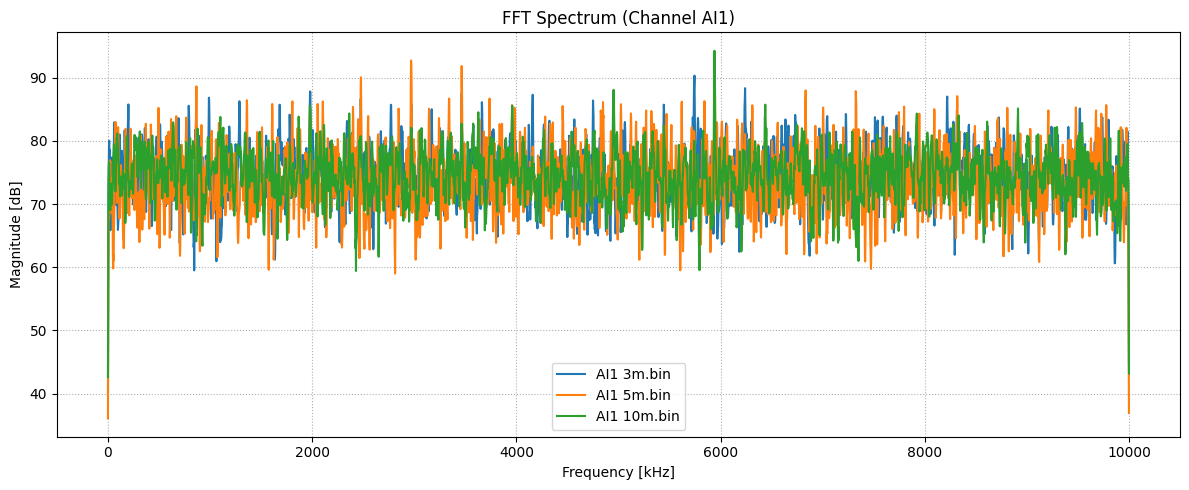

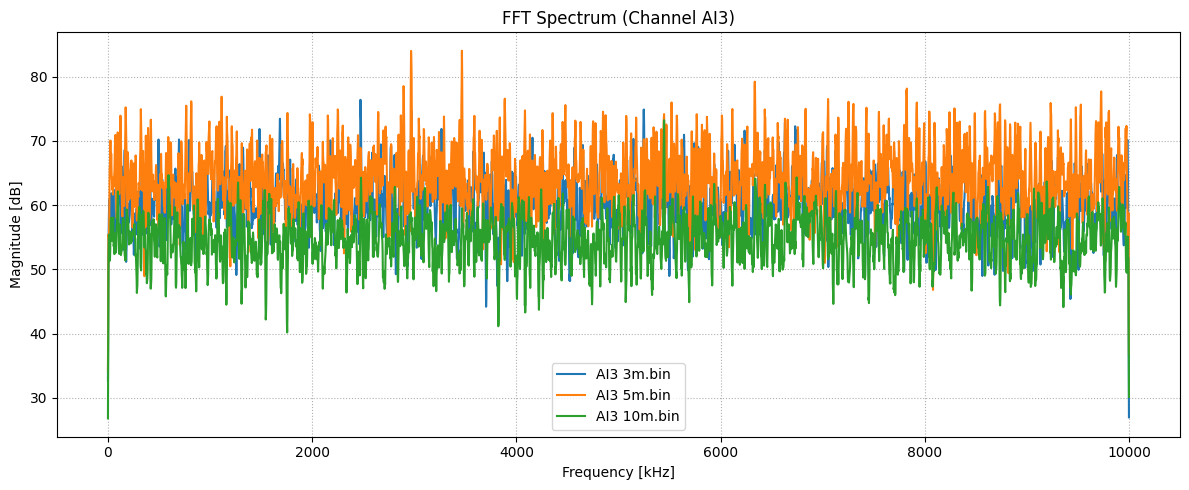

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
for item in results:
    ch_fft = item["analysis"]["ch1_fft"]
    plt.plot(
        ch_fft["frequencies"],
        ch_fft["magnitudes"],
        label=f"AI1 {item['path'].name}"
    )
plt.xlabel("Frequency [kHz]")
plt.ylabel("Magnitude [dB]")
plt.title("FFT Spectrum (Channel AI1)")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()

plt.figure(figsize=(12, 5))
for item in results:
    ch_fft = item["analysis"]["ch2_fft"]
    plt.plot(
        ch_fft["frequencies"],
        ch_fft["magnitudes"],
        label=f"AI3 {item['path'].name}"
    )
plt.xlabel("Frequency [kHz]")
plt.ylabel("Magnitude [dB]")
plt.title("FFT Spectrum (Channel AI3)")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()

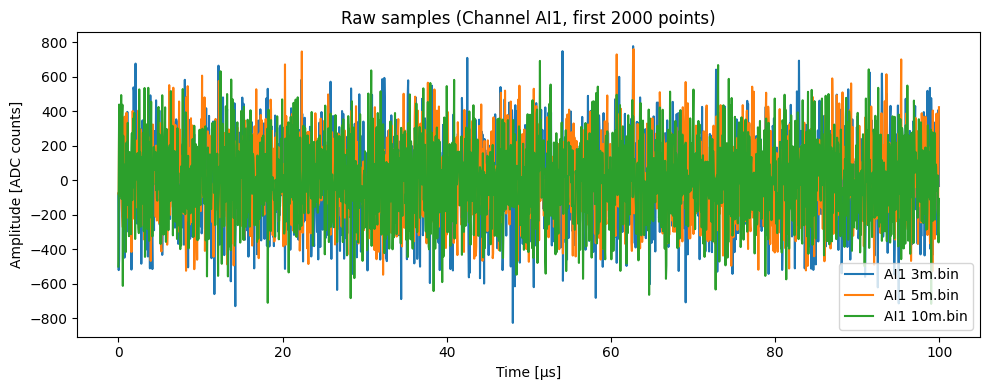

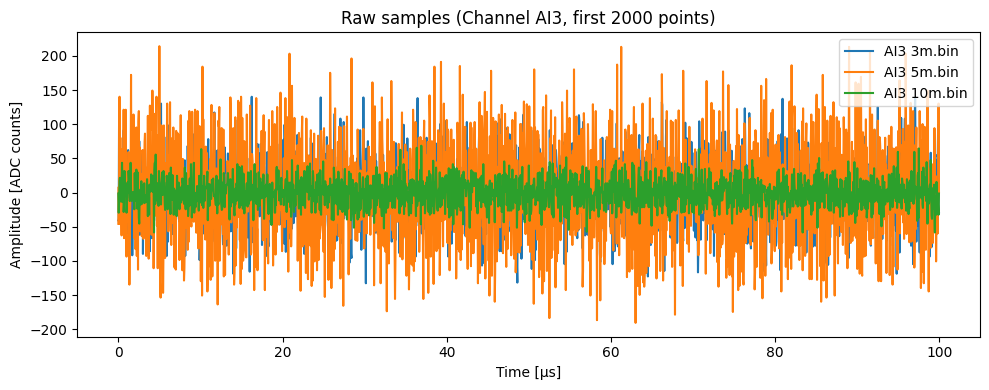

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for item in results:
    data_dict = item["data"]
    time_axis = data_dict["time_axis"]
    ch1 = data_dict["ch1"]
    plt.plot(
        time_axis[:2000] * 1e6,
        ch1[:2000],
        label=f"AI1 {item['path'].name}"
    )
plt.xlabel("Time [µs]")
plt.ylabel("Amplitude [ADC counts]")
plt.title("Raw samples (Channel AI1, first 2000 points)")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10, 4))
for item in results:
    data_dict = item["data"]
    time_axis = data_dict["time_axis"]
    ch3 = data_dict["ch2"]
    plt.plot(
        time_axis[:2000] * 1e6,
        ch3[:2000],
        label=f"AI3 {item['path'].name}"
    )
plt.xlabel("Time [µs]")
plt.ylabel("Amplitude [ADC counts]")
plt.title("Raw samples (Channel AI3, first 2000 points)")
plt.legend()
plt.tight_layout()